# k-sparse parity 

**Report**:

- Experiments with the decoder-only Transformer (``Autobots_v2.py``) were useless. Nothing was learned, even for the low sensitivity case ($k = 4$, $n=4$)
- Now, we try the full transformer (``ucan_transformer.py``).


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.cuda.amp import GradScaler, autocast
import random
import math
import pickle
from functools import partial
from time import time
from Autobots_v2 import AutobotConfig, Autobot

%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore")

**Auxiliay functions**

In [3]:
def generate_sequences(n, k, num_sequences):

    dataset = []
    subseq_idx = np.random.choice(np.arange(n - 1), k, replace=False)
    in_subset = np.zeros(n-1, dtype=np.bool_)
    in_subset[subseq_idx] = 1

    for _ in range(num_sequences):
            
        seq = [np.random.randint(0,2) for _ in range(n-1)]
        
        if np.sum(seq, where=in_subset) % 2 == 0:
            new_seq = seq + [0]
        else:
            new_seq = seq + [1]
    
        dataset.append(new_seq)

    return dataset


def shift_and_append(raw_data, shift_step=1):
    
    out = []
    
    for sample in raw_data:

        X = torch.tensor(sample[:-shift_step])
        y = torch.tensor(sample[shift_step:])

        out.append([X,y])
        
    return out


def train_loop(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    
    # the dataloader is expected to be an iterator generated by torch.utils.data.DataLoader
    for batch in dataloader:
        
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, dataloader, device, eval_mode=True):
    
    if eval_mode:
        model.eval()
    else:
        pass

    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            logits, loss = model(X, y)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def last_token_acc(model, dataloader, device):
    
    model.eval()
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model.generate(X, max_new_tokens=1)
            correct += (y_pred[:,-1] == y[:,-1]).sum().item()
            total += y.shape[0]
    
    return correct / total

In [6]:
##################### GLOBAL PARAMETERS ########################

VERSION = '1.1' 
SEED = 48898989

GENERATE_DATA = True
TRAIN_MODEL = True
LOAD_PERFORMANCE_REPORT = False

DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# Data parameters
N = 20
k = 4
NUM_SEQUENCES = 40000

TRAIN_FRACTION = 0.7
VAL_FRACTION = 0.15
TEST_FRACTION = 0.15
BATCH_SIZE = 32


# Architecture
NUMBER_LAYERS = 8
NUMBER_HEADS = 8
D_MODEL = 8
DROPOUT = 0
D_FF = 1024
ACTIVATION = 'relu'
USE_STANDARD_POSITIONAL_ENCODING = True
TIE_WEIGHTS_OUTPUT = False 
CONTEXT_SIZE = 500
LEARNING_RATE = 0.001
BETA_1 = 0.9
BETA_2 = 0.98
EPS = 10**(-9)

EPOCHS = 5



# Set random seed for reproducibility
torch.manual_seed(SEED)
np.random.seed(SEED)


# Path to the relevant folders

TRAIN_DATASET = f'datasets/sparse_parity_train_data_version_{VERSION}'
VAL_DATASET = f'datasets/sparse_parity_val_data_version_{VERSION}'
TEST_DATASET = f'datasets/sparse_parity_test_data_version_{VERSION}'
PARAMS_PATH = f'saved_models/sparse_parity_model_params_version_{VERSION}.pt'
MODEL_PATH = f'saved_models/sparse_parity_model_version_{VERSION}.pt'
HISYORY_PATH = f'saved_models/sparse_parity_model_history_version_{VERSION}.pkl'
PERFORMANCE_REPORT = f'saved_models/sparse_parity_model_performance_version_{VERSION}.txt'

#########################################################

## Dataset

In [7]:
def generate_sequences(n, k, num_sequences):

    dataset = []
    subseq_idx = np.random.choice(np.arange(n - 1), k, replace=False)
    in_subset = np.zeros(n-1, dtype=np.bool_)
    in_subset[subseq_idx] = 1

    for _ in range(num_sequences):
            
        seq = [np.random.randint(0,2) for _ in range(n-1)]
        
        if np.sum(seq, where=in_subset) % 2 == 0:
            new_seq = seq + [0]
        else:
            new_seq = seq + [1]
    
        dataset.append(new_seq)

    return dataset


def shift_and_append(raw_data, shift_step=1):
    
    out = []
    
    for sample in raw_data:

        X = torch.tensor(sample[:-shift_step])
        y = torch.tensor(sample[shift_step:])

        out.append([X,y])
        
    return out


def train_loop(model, optimizer, dataloader, device):
    model.train()
    total_loss = 0
    
    # the dataloader is expected to be an iterator generated by torch.utils.data.DataLoader
    for batch in dataloader:
        
        X, y = batch
        X = X.to(device)
        y = y.to(device)
        logits, loss = model(X, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)

def validation_loop(model, dataloader, device, eval_mode=True):
    
    if eval_mode:
        model.eval()
    else:
        pass

    total_loss = 0
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            logits, loss = model(X, y)
            total_loss += loss.detach().item()
        
    return total_loss / len(dataloader)


def last_token_acc(model, dataloader, device):
    
    model.eval()
    correct = 0
    total = 0
    
    
    with torch.no_grad():
        
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)
            y_pred = model.generate(X, max_new_tokens=1)
            correct += (y_pred[:,-1] == y[:,-1]).sum().item()
            total += y.shape[0]
    
    return correct / total

In [9]:
if GENERATE_DATA:

    raw_data = generate_sequences(N, k, NUM_SEQUENCES)
    source_target_sequences = shift_and_append(raw_data, shift_step=1)
    train_data, val_data, test_data = random_split(source_target_sequences, [TRAIN_FRACTION, VAL_FRACTION, TEST_FRACTION])

    # torch.save(train_data, TRAIN_DATASET)
    # torch.save(val_data, VAL_DATASET)
    # torch.save(test_data, TEST_DATASET)

    train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
    val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


    print(f'Number of training samples: {len(train_data)}')
    print(f'Number of validation samples: {len(val_data)}')
    print(f'Number of test samples: {len(test_data)}')

else:

    # train_data = torch.load(TRAIN_DATASET)
    # val_data = torch.load(VAL_DATASET)
    # test_data = torch.load(TEST_DATASET)


    # train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    # test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)
    # val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


    print(f'Number of training samples: {len(train_data)}')
    print(f'Number of validation samples: {len(val_data)}')
    print(f'Number of test samples: {len(test_data)}')

Number of training samples: 28000
Number of validation samples: 6000
Number of test samples: 6000


In [6]:
### Data sample
sample = train_data[0]
X, y = sample
print(f'X: {X}')
print(f'y: {y}')

X: tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0])
y: tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1])


In [7]:
if LOAD_PERFORMANCE_REPORT:
    with open(PERFORMANCE_REPORT, 'rb') as f:
        performance_report = pickle.load(f)

        print(performance_report)

## Training the model

In [8]:
parameters_dict = {'context_size': CONTEXT_SIZE,
                     'vocab_size': 2,
                     'n_layer': NUMBER_LAYERS,
                     'n_head': NUMBER_HEADS,
                     'd_model': D_MODEL,
                     'dropout': DROPOUT,
                     'd_ff': D_FF,
                     'activation': ACTIVATION,
                     'standard_positional_encoding': USE_STANDARD_POSITIONAL_ENCODING,
                     'tie_weights': TIE_WEIGHTS_OUTPUT,
                     'tgt_is_causal': False}



harvey_dent = Autobot(AutobotConfig(**parameters_dict))
harvey_dent = harvey_dent.to(DEVICE)
print(f'Number of parameters (exact): {sum(p.numel() for p in harvey_dent.parameters())}')

optimizer = torch.optim.Adam(harvey_dent.parameters(), lr=LEARNING_RATE, betas=(BETA_1, BETA_2), eps=EPS)

if TRAIN_MODEL:

    with open(PARAMS_PATH, 'wb') as f:
        pickle.dump(parameters_dict, f)

    train_losses = []
    validation_losses = []

    for _ in range(EPOCHS):
        print(f'Epoch {_+1}/{EPOCHS}')
        train_loss = train_loop(harvey_dent, optimizer, train_dataloader, DEVICE)
        val_loss = validation_loop(harvey_dent, val_dataloader, DEVICE)
        train_losses.append(train_loss)
        validation_losses.append(val_loss)


    df_history = pd.DataFrame({'train_loss': train_losses, 'validation_loss': validation_losses})
    df_history.to_csv(HISYORY_PATH, index=False)
      
    torch.save(harvey_dent.state_dict(), MODEL_PATH)

else:
    with open(PARAMS_PATH, 'rb') as f:
        parameters_dict = pickle.load(f)

    harvey_dent = Autobot(AutobotConfig(**parameters_dict))
    harvey_dent.load_state_dict(torch.load(MODEL_PATH))
    harvey_dent.to(DEVICE)
    df_history = pd.read_csv(HISYORY_PATH)

number of parameters: 0.14M
Number of parameters (exact): 144368
Epoch 1/5
Epoch 2/5
Epoch 3/5
Epoch 4/5
Epoch 5/5


## Assessing performance 

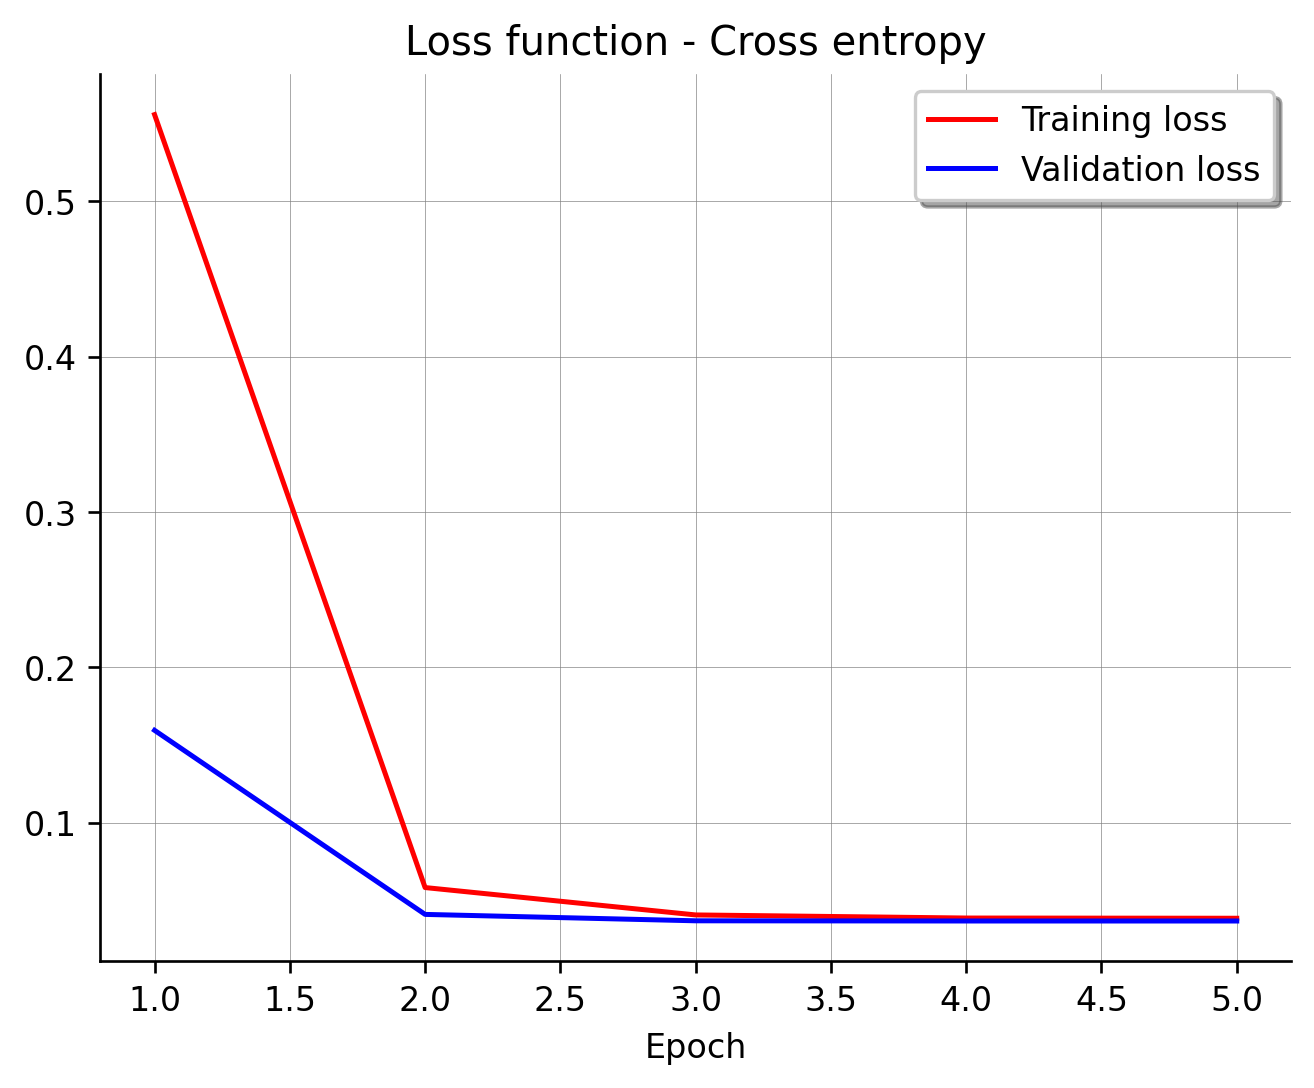

In [9]:
fig, ax = plt.subplots(dpi=120)

train_loss_list = df_history["train_loss"].values
val_loss_list = df_history["validation_loss"].values

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_title("Loss function - Cross entropy")
ax.plot(range(1, len(df_history) + 1), train_loss_list, color='red', label='Training loss')
ax.plot(range(1, len(df_history) + 1), val_loss_list, color='blue', label='Validation loss')
ax.set_xlabel('Epoch')
ax.grid(lw=0.2, color='gray');
ax.legend(fancybox=True, shadow=True);
ax.grid(lw=0.2, color='gray');

In [10]:
    
last_token_acc_train = last_token_acc(harvey_dent, train_dataloader, device=DEVICE)
last_token_acc_val = last_token_acc(harvey_dent, val_dataloader, device=DEVICE)
last_token_acc_test = last_token_acc(harvey_dent, test_dataloader, device=DEVICE)    

performance_report = dict()

performance_report['VERSION'] = VERSION
performance_report['train_last_token_accuracy'] = last_token_acc_train
performance_report['val_last_token_accuracy'] = last_token_acc_val
performance_report['test_last_token_accuracy'] = last_token_acc_test
performance_report['N'] = N
performance_report['k'] = k
performance_report['num_sequences_train'] = len(train_data)


with open(PERFORMANCE_REPORT, 'wb') as f:
    pickle.dump(performance_report, f)

print(f'Training last token accuracy: {last_token_acc_train}')
print(f'Validation last token accuracy: {last_token_acc_val}')
print(f'Test last token accuracy: {last_token_acc_test}')

Training last token accuracy: 0.5006785714285714
Validation last token accuracy: 0.496
Test last token accuracy: 0.5056666666666667


In [11]:
print(f'Version executed: {VERSION}')

Version executed: 1.1
